# Stack Overflow - Clustering

This notebook continues exploring the the data of the GADS23 Kaggle Stack Overflow competition.

Your goal was to build a classifier that predicts whether or not a question will be closed given the question as submitted.

Let's see if clustering would be helpful

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("/Users/ruben/Downloads/train.csv", index_col=0)

### Tags
One obvious candidate for clustering would be the vast amount of tags we have.

In [3]:
%%time
data['tags'] = data.apply(lambda x: " ".join(set(str(x['Tag%d' % i]) for i in xrange(1, 6))), axis=1)
data['tags'] = data['tags'].str.replace('nan', '').str.replace("  ", " ").str.strip()

CPU times: user 5.42 s, sys: 105 ms, total: 5.53 s
Wall time: 5.49 s


In [4]:
tags = set([tag for tags in data.tags.values for tag in tags.split()])
print "We have", len(tags), "tags."

We have 18309 tags.


That is a lot. We could maybe cluster these, and then feed the cluster category into the model, rather than an ID for one of the 18K tags.  We could use `CountVectorizer` for this again.

In [5]:
n_clusters = 10
# N = 10000  # only use the first N documents for clustering (to speed up computations)
# data = data.iloc[:N]

In [6]:
%%time
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1), max_features=5000, min_df=10, max_df=.95, binary=True)
X = cv.fit_transform(data.tags)

CPU times: user 1.01 s, sys: 22.8 ms, total: 1.04 s
Wall time: 1.03 s


#### Clustering tags by their documents

In [7]:
XT = X.T
XT = StandardScaler().fit_transform(XT.toarray().astype(float))

In [8]:
%%time
model = KMeans(n_clusters=n_clusters)
model.fit(XT)

CPU times: user 4min 35s, sys: 3.03 s, total: 4min 38s
Wall time: 1min 39s


In [9]:
np.unique(model.predict(XT), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([   1,    1, 3226,    1,    1,    1,    1,    1,    1,    1]))

Hmm, that didn't quite work: almost all tags got into one cluster, and the other clusters just got one tag. (Note we have less tags since we only used part of the data.)

#### Clustering documents by their tags

One other way we could do, is clustering the documents according to their tags, and then use their document cluster to feed into the model.

In [10]:
%%time
model.fit(X)

CPU times: user 36.4 s, sys: 97.9 ms, total: 36.5 s
Wall time: 36.5 s


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [11]:
np.unique(model.predict(X), return_counts=True)

/Users/ruben/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:862: RuntimeWarning: Got data type int64, converted to float to avoid overflows
  X = self._check_test_data(X)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 4143,  4314,  1807,  6427,  8624, 10950, 12022,  4622,  5960, 81403]))

Much better! Let's inspect the most common tags in these clusters.

In [12]:
top = 12
print "Top %d tags per cluster:" % top
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()
for i in range(n_clusters):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :top]:
        print terms[ind],
    print

Top 12 tags per cluster:
Cluster 0: sql server 2008 mysql database 2005 net tsql query linq oracle windows
Cluster 1: html css javascript jquery internet explorer html5 css3 div php browser web
Cluster 2: visual studio 2010 net 2008 asp windows vb sql 2005 debugging server
Cluster 3: jquery javascript ajax php html ui css plugins mobile json html5 forms
Cluster 4: android java layout eclipse listview google iphone emulator application mobile sqlite activity
Cluster 5: java ee swing spring web eclipse javascript hibernate jsp php xml multithreading
Cluster 6: php mysql javascript html php5 arrays wordpress codeigniter database sql apache facebook
Cluster 7: python django google ruby engine app php list web regex mysql numpy
Cluster 8: net asp mvc jquery javascript ajax web sql vb framework entity server
Cluster 9: iphone javascript net ruby objective ios rails windows linux mysql facebook google


Seems like there are at least a front-end cluster, a database cluster, and a mobile cluster.  Note that, since we clustered documents, not tags, a tag might be associated with several clusters.

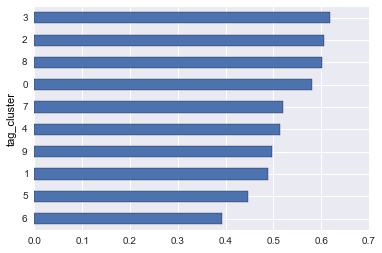

In [13]:
data['tag_cluster'] = model.predict(X)
s = data.groupby('tag_cluster').OpenStatus.mean().sort(inplace=False)
f = s.plot(kind='barh')

The difference in closed posts per cluster suggests we could try extracting some value from this.  We leave it as an exercise to verify if adding these clusters to your feature matrix indeed leads to a higher preduction accuracy.

#### Jaccard distance

The [_Jaccard index_](https://en.wikipedia.org/wiki/Jaccard_index) is a similarity metric between text documents. It measures how many words two documents have in common, as a fraction of the total number of distinct words in both documents.

$$\text{Jaccard index} = \frac{ |A \cap B | }{ |A \cup B| }$$

We could make a Jaccard matrix $J$, with pairwise similarities $J_{ij}$ as entries.
- `J[i, j]` = Jaccard similarity between doc _i_ and _j_ (between 0 and 1)
- `J[i, i]` = 1, obviously, and
- `J[i, j]` = `J[i, j]`, i.e., the matrix is symmetric.

We could also define the _Jaccard distance_, which has $D_{ii} = 0$ for identical documents, and bigger values as the documents have less words in common.  We define: $D = 1 - J,$ which has values between 0 and 1.

We could also use this for comparing our tags: how many documents do two tages have in common?

In [14]:
%%time
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1), max_features=5000,
                     min_df=10, max_df=.95, binary=True)  # binary=True is important!
X = cv.fit_transform(data.tags)

CPU times: user 916 ms, sys: 23.3 ms, total: 939 ms
Wall time: 926 ms


Compute the Jaccard matrix and the distance matrix.

In [15]:
n_tags = X.shape[1]  # number of tags
I = X.T.dot(X).toarray()  # X-transposed times X gives a tag x tag matrix with the # of docs in common
n_docs = np.diag(I)  # number of docs per tag
# U = np.array([[n_docs[i] + n_docs[j] - I[i, j] for i in xrange(n_tags)] for j in xrange(n_tags)])  # this is slow
N = np.array([n_docs] * n_tags)  # number of docs broadcasted over the entire row
U = N + N.T - I  # total distinct docs = n_docs_i + n_docs_j - words in common
J = I / U.astype(float)
D = 1 - J

Let's pick a few random tags and see what the closest tags are.

In [16]:
top = 10
tags = np.array(cv.get_feature_names())
for no in np.random.choice(n_tags, top, replace=False):  # pick 10 random tags
    print "%-18s:" % tags[no], " ".join(tags[D[no].argsort()[:top]])

w3c               : w3c validation xhtml standards dtd logo compliance validator digital crud
recaptcha         : recaptcha captcha googlebot messagebox prevention spam iframe message redirect error
jdk7              : jdk7 jdk1 jdk nio jython jre classes closures jruby production
carrierwave       : carrierwave rmagick paperclip rackspace asset pipeline gem compare cloud rails
analytics         : analytics google tracking mining flurry usage statistics api intelligence analysis
getter            : getter setter phpdoc encapsulation notation dot member blank dao nullpointerexception
flexbuilder       : flexbuilder flex4 flex flex3 adobe air actionscript builder access source
change            : change password itil isotope radio src textfield detect portlet sas
axapta            : axapta ax 2009 dynamics 2012 cobol methods career development forms
relational        : relational algebra database non foreign nosql relationship schema databases backbone


Makes sense. Some tags have more meaning than others, I expect. Note that this is not a partitioning, as we only have a distance between words.

We could also apply `KMeans` to this Jaccard matrix, as the entries are indeed distances.

In [17]:
model.fit(D)
print "Top %d tags per cluster:" % top
order_centroids = model.cluster_centers_.argsort()
for i in range(n_clusters):
    print "Cluster %d:" % i, " ".join(tags[order_centroids[i, :top]])

Top 10 tags per cluster:
Cluster 0: graduate school masters degree college education systems university science old
Cluster 1: web cream sandwich ice net asp internet iphone explorer ios
Cluster 2: studio visual 2010 server engine 2008 sql opengl xna app
Cluster 3: fault segmentation gdb berkeley scanf resque sfml jit nasm slots
Cluster 4: password conf httpd protection passwords recovery alias salt storage encryption
Cluster 5: unit tests automated testing mocks tdd rhino integration continuous driven
Cluster 6: lotus domino asset notes package pipeline 04 10 directory active
Cluster 7: style coding ref counting anonymous handling automatic event types exception
Cluster 8: garbage collection ruby rails programming lisp node js languages clojure
Cluster 9: procedures stored plsql 2005 cursor server sql tsql oracle db2


That looks quite promising.

Unfortunately, the model has put a lot of tags into the same cluster again:

In [18]:
np.unique(model.predict(D), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([   7, 2878,  104,    2,   11,   35,   43,   52,  101,    2]))

<hr>
## Exercise
- Add the cluster information to your feature set and train a model on your data. Does the inclusion of these clusters indeed imporve prediction accuracy?  (Don't forget to cross-validate.)
- Try different values for `n_clusters` and see if you could find a good value using the _elbow method_.

We have looked at clustering tags by documents, clustering documents by tags, and at the Jaccard distance between two tags using the number of documents they have in common.  
- Could you think of other ways of clustering tags or documents?  Try to implement these and see how effective they are.